<a href="https://colab.research.google.com/github/FabrizioCabreraC/Hollywood-as-recession-proof/blob/main/Hollywood_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
#%pip install cpi
%matplotlib inline
#%pip install scrapy
#import scrapy
import requests
%pip install fredapi
from fredapi import Fred #package for pulling from FRED API

To try and answer the question of how recession proof the film in industry is we collected data from three different sources. 

Economic data was from the Federal Reserve Economic Database through the use of the FRED API. More specifically the fredapi package was used with a custom built funtion to pull individal series. This data includes, (but may not be linited to in the final draft) real GDP, CPI, Unemployment Rate, Consumer Confidence, real GDP per capita, and the Fed Funds Rate. The time series collected for these indicator varies, but was restructed to either show monthy (if available), or quarterly data. As of this moment all the variables were merged to start in 1990, as this is when gas price was first measured, but the data many be concatinated to allow a deeper range of years for the variables that have more data. 

Box office data was pulled from the monthly domestic box office tables on the website BoxOffice Mojo through read.html. This data was also modfied to show quarelty sums of total box office revneue and total films released. The quartely data was then merged into the data_qrt dataframe with the economic indicators.

In order to obtain the average review ratings of movies released each year further film data was taken from links to the IMDB database.  More specifcially the title.basics.tsv.gz and the title.ratings.tsv.gz tables from the IMDB data sets. These two data sets have been merged together to provide the yearly average review scores for all movies released. It has not yet been merged into the data.qrt table as it can only be measured buy the year, and we are now unsure if it will need to be used in the final project. 

Visualizations to be displayed will include charts showing the relationship between certain macroeconomic indicators and the supply and demand of the film industry since the 1980s. For instance, the charts will display a time series analysis that shows the state of the economy during those years. Thus, it will be observable how well the box office did during the recessions. Then, we would evaluate what happened in the cinema entertainment with respect to each variable: GDP, CPI, Unemployment Rate, Consumer Confidence, GDP per capita, the Fed Funds Rate. The charts will not only show the box office performance, but they will also display the market share movements related to the film industry during the pertinent period. In such a way, it will be seen whether Hollywood was affected by recessions and/or other non-economic factors, and by how much.

Section 1: Pulls desired economic data series from FRED API

In [2]:
fred = Fred(api_key = "ef5451a7d8f6d761a7f3fb042aebd7da") 
# my API Key, careful with it I guess.
# this is a fucntion the uses fredapi packages to easily retrive series

In [3]:
def get_fred (series_code: str):
    '''
    Pulls data from FRED API in the form of a series and returns cleaned 
    data set
    
    parameter
    --------
    sereies_code: Code for specific data sereis complied on FRED website 
    
    returns:
    --------
    dataframe: a dataframe of the FRED metric according to the data series
    given to the function
    '''
    fred = Fred(api_key = "ef5451a7d8f6d761a7f3fb042aebd7da")
    
    data = fred.get_series(f"{series_code}")
    dataframe = pd.DataFrame(data)
    data_rn = {0 : f"{series_code}"}
    cleaned = dataframe.rename(data_rn, axis=1)
    cleaned = cleaned.reset_index()
    a = {"index": "Date"}
    cleaned = cleaned.rename(a, axis = 1)
    cleaned["Date"] = pd.to_datetime(cleaned["Date"])
    return cleaned

Below use the get_fred fucntion to obatin the desiresed series that will be cleaned and put into a data set.

In [4]:
unemp = get_fred("UNRATE") # unemplyment rate, by month
#unemp
GDP = get_fred("GDPC1") #nominal, by quater, real gdp
#GDP
consumer_sent = get_fred("UMCSENT") # U Mich consumer sentiment, by month
#consumer_sent
debt_income = get_fred("TDSP") #total debt service to income ratio, by quater
#debt_income
gdp_capita = get_fred("A939RX0Q048SBEA") #real ratio, by quater 
#gdp_capita
gas_prices = get_fred("GASREGCOVW") #national gas price average, by week
#gas_prices
inflation = get_fred("FPCPITOTLZGUSA") #inflation rate, by year
#inflation
PCE = get_fred("DPCERD3Q086SBEA") #PCE with index set to 2012, quarterly
#PCE

Renaming the series to be more legible and useable.

In [5]:
j = {"GDPC1" : "GDP"}
GDP = GDP.rename(j, axis=1)
#GDP

p = {"DPCERD3Q086SBEA": "PCE"}
PCE = PCE.rename(p, axis =1 )
#PCE

i = {"FPCPITOTLZGUSA" : "inflat_index"}
inflation = inflation.rename(i, axis=1)
#inflation

Consum_Sent = {"UMCSENT" : "consum_sent"}
consumer_sent = consumer_sent.rename(Consum_Sent, axis=1)
#consumer_sent

gas = {"GASREGCOVW" : "gas_price"}
gas_prices = gas_prices.rename(gas, axis=1)
gas_prices = (gas_prices.set_index("Date").
              resample("MS").mean().
              reset_index())
#gas_prices

jeff = {"A939RX0Q048SBEA" : "gdp_per_capita"}
gdp_capita = gdp_capita.rename(jeff, axis=1)
#GDP_per_capita

debt_pct_income = {"TDSP" : "debt_pct_income"}
debt_income = debt_income.rename(debt_pct_income, axis=1)
#Debt_Payment

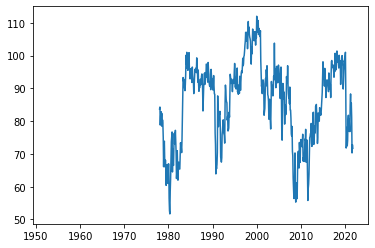

In [6]:
#quick example plot
plt.plot(consumer_sent.Date, consumer_sent.consum_sent)

In [7]:
data_month = unemp.merge(consumer_sent.merge(gas_prices, on="Date", how="outer"))
#data_month.head(10)

data_qrt = data_month.set_index("Date").resample("QS").mean().reset_index()
#data_qrt.head(10)

data_qrt = data_qrt.merge(
    GDP.merge(
    gdp_capita.merge(
    PCE.merge(
    debt_income, on="Date", how = "outer"))))
#data_qrt.head()

data_year = data_qrt.set_index("Date").resample("YS").mean()

Pulling in Data From Box Office Mojo

In [8]:
def get_table(url):
    '''
    Function gets the datatable requesuted from the boxoffice mojo
    url and outputs to a dataframe
    '''
    response = requests.get(url).content
    table = pd.read_html(response)
    table_df = pd.DataFrame(table[-1])
    return table_df

In [9]:
url = "https://www.boxofficemojo.com/year/?ref_=bo_nb_ml_secondarytab"
box_year = get_table(url)
box_year.head()

,Year,Total Gross,%± LY,Releases,Average,#1 Release
0,2021,"$3,617,121,325",-,408,"$8,865,493",Shang-Chi and the Legend of the Ten Rings
1,2020,"$2,103,085,767",-81.4%,455,"$4,622,166",Bad Boys for Life
2,2019,"$11,320,872,943",-4.8%,911,"$12,426,863",Avengers: Endgame
3,2018,"$11,889,341,443",+7.4%,993,"$11,973,153",Black Panther
4,2017,"$11,072,815,067",-2.7%,852,"$12,996,261",Star Wars: Episode VIII - The Last Jedi


In [10]:
def reduce_table_year(df):
    jeff = df.drop(['%± LY', "Average", '#1 Release'], axis=1)
    jeff["Date"]= pd.to_datetime(jeff['Year'], format="%Y")
    return jeff

In [11]:
box_office_year = reduce_table_year(box_year)
box_office_year.head()

,Year,Total Gross,Releases,Date
0,2021,"$3,617,121,325",408,2021-01-01
1,2020,"$2,103,085,767",455,2020-01-01
2,2019,"$11,320,872,943",911,2019-01-01
3,2018,"$11,889,341,443",993,2018-01-01
4,2017,"$11,072,815,067",852,2017-01-01


In [12]:
box_jan = get_table("https://www.boxofficemojo.com/month/january/?grossesOption=calendarGrosses")
box_feb = get_table("https://www.boxofficemojo.com/month/february/?grossesOption=calendarGrosses")
box_mar = get_table("https://www.boxofficemojo.com/month/march/?grossesOption=calendarGrosses")
box_apr = get_table("https://www.boxofficemojo.com/month/april/?grossesOption=calendarGrosses")
box_may = get_table("https://www.boxofficemojo.com/month/may/?grossesOption=calendarGrosses")
box_jun = get_table("https://www.boxofficemojo.com/month/june/?grossesOption=calendarGrosses")
box_jul = get_table("https://www.boxofficemojo.com/month/july/?grossesOption=calendarGrosses")
box_aug = get_table("https://www.boxofficemojo.com/month/august/?grossesOption=calendarGrosses")
box_sep = get_table("https://www.boxofficemojo.com/month/september/?grossesOption=calendarGrosses")
box_oct = get_table("https://www.boxofficemojo.com/month/october/?grossesOption=calendarGrosses")
box_nov = get_table("https://www.boxofficemojo.com/month/november/?grossesOption=calendarGrosses")
box_dec = get_table("https://www.boxofficemojo.com/month/december/?grossesOption=calendarGrosses")
box_q1 = get_table("https://www.boxofficemojo.com/quarter/q1/?grossesOption=calendarGrosses")
box_q2 = get_table("https://www.boxofficemojo.com/quarter/q2/?grossesOption=calendarGrosses")
box_q3 = get_table("https://www.boxofficemojo.com/quarter/q3/?grossesOption=calendarGrosses")
box_q4 = get_table("https://www.boxofficemojo.com/quarter/?ref_=bo_nb_ml_secondarytab")

In [13]:
def reduce_table(df, month: int):
    jeff = df.drop(['%± LY', '#1 Release', 'Gross','% of Total',
                    'Genre', 'Budget', 'Running Time'], axis=1)
    jeff["month"] = month
    jeff["Date"]= pd.to_datetime(jeff[['Year', 'month']].assign(DAY=1))
    return jeff

In [14]:
box_jan = reduce_table(box_jan,1)
box_feb = reduce_table(box_feb,2)
box_mar = reduce_table(box_mar,3)
box_apr = reduce_table(box_apr,4)
box_may = reduce_table(box_may,5)
box_jun = reduce_table(box_jun,6)
box_jul = reduce_table(box_jul,7)
box_aug = reduce_table(box_aug,8)
box_sep = reduce_table(box_sep,9)
box_oct = reduce_table(box_oct,10)
box_nov = reduce_table(box_nov,11)
box_dec = reduce_table(box_dec,12)
box_q1 = reduce_table(box_q1,1)
box_q2 = reduce_table(box_q2,4)
box_q3 = reduce_table(box_q3,7)
box_q4 = reduce_table(box_q4,10)

In [15]:
box_office = (pd.concat([box_jan,box_feb,box_mar,box_apr,box_may,box_jun,
                        box_jul,box_aug,box_sep, box_oct, box_nov, box_dec],
                       axis = 0)
              .sort_values(by=["Date"])
              .set_index("Date")
              .drop(["Year",'month'], axis=1))
box_office["gross"] = (box_office["Cumulative Gross"]
                                  .str.replace("$", "")
                                  .str.replace(",", "")
                                  .astype(int))

box_office_month = box_office.copy()
box_office_month.head()

box_office_qrt = (pd.concat([box_q1,box_q2,box_q3,box_q4], axis = 0)
              .sort_values(by=["Date"])
              .set_index("Date")
              .drop(["Year",'month'], axis=1))
box_office_qrt["gross"] = (box_office_qrt["Cumulative Gross"]
                                  .str.replace("$", "")
                                  .str.replace(",", "")
                                  .astype(int))

box_office_year = box_office_year.sort_values(by=["Date"]).set_index("Date").drop(["Year"], axis=1).reset_index()

box_office_year["gross"] = (box_office_year["Total Gross"]
                                  .str.replace("$", "")
                                  .str.replace(",", "")
                                  .astype(int))
box_office_year = box_office_year.drop("Total Gross", axis=1)

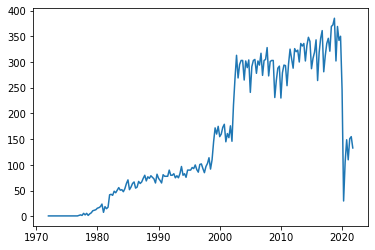

In [16]:
plt.plot(box_office_qrt.Releases)

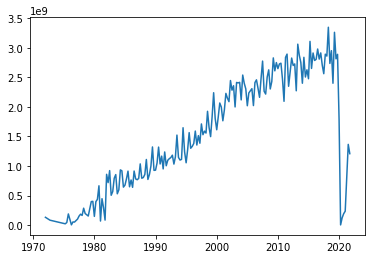

In [17]:
plt.plot(box_office_qrt.gross)

In [18]:
data_qrt_box = data_qrt.merge(box_office_qrt, on="Date", how="outer")
# to account for inflation in the data to 2012 index
data_qrt_box["PCE"] = data_qrt_box["PCE"] * .01
data_qrt_box["gas_price"] = data_qrt_box["gas_price"]/data_qrt_box["PCE"]
data_qrt_box["gross"] = data_qrt_box["gross"]/data_qrt_box["PCE"]
# so the data starts in 1982 when the gross starts to make more sense
data_qrt_box = data_qrt_box.set_index("Date").loc["1982":"2020"]
data_qrt_box.head()

,UNRATE,consum_sent,gas_price,GDP,gdp_per_capita,PCE,debt_pct_income,Cumulative Gross,Releases,Average,gross
Date,,,,,,,,,,,
1982-01-01,8.833333,66.500000,NaN,6799.233,29384.0,0.46521,10.447258,"$860,141,240",42.0,"$20,479,553",1.848931e+09
1982-04-01,9.433333,66.233333,NaN,6830.251,29453.0,0.46967,10.504029,"$720,075,945",43.0,"$16,745,952",1.533153e+09
1982-07-01,9.900000,66.700000,NaN,6804.139,29265.0,0.47707,10.409941,"$923,079,585",41.0,"$22,514,136",1.934893e+09
1982-10-01,10.666667,72.466667,NaN,6806.857,29205.0,0.48232,10.380410,"$506,071,250",49.0,"$10,327,984",1.049244e+09
1983-01-01,10.366667,75.266667,NaN,6896.561,29530.0,0.48629,10.348922,"$568,106,713",46.0,"$12,350,145",1.168247e+09


In [19]:
box_office_year.head()

,Date,Releases,gross
0,1977-01-01,9,443497478
1,1978-01-01,13,840508376
2,1979-01-01,40,1244961893
3,1980-01-01,68,1657166297
4,1981-01-01,56,918310755


In [20]:
data_box_year = data_year.merge(box_office_year, on="Date", how="outer")
# to account for inflation in the data to 2012 index
data_box_year["PCE"] = data_box_year["PCE"] * .01
data_box_year["gas_price"] = data_box_year["gas_price"]/data_box_year["PCE"]
data_box_year["gross"] = data_box_year["gross"]/data_box_year["PCE"]
# so the data starts in 1982 when the gross starts to make more sense
data_box_year = data_box_year.set_index("Date").loc["1982":"2020"]
data_box_year.head()

,UNRATE,consum_sent,gas_price,GDP,gdp_per_capita,PCE,debt_pct_income,Releases,gross
Date,,,,,,,,,
1982-01-01,9.708333,67.975000,NaN,6810.1200,29326.75,0.473567,10.435410,132.0,6.352538e+09
1983-01-01,9.600000,87.383333,NaN,7122.2905,30392.50,0.493670,10.383022,149.0,5.567348e+09
1984-01-01,7.508333,97.475000,NaN,7637.7040,32308.50,0.512373,10.671112,169.0,6.058671e+09
1985-01-01,7.191667,93.166667,NaN,7956.1695,33357.25,0.530250,11.463162,191.0,5.735936e+09
1986-01-01,7.000000,94.791667,NaN,8231.6635,34200.75,0.541813,11.882739,201.0,5.726693e+09


In [21]:
# original data cleaning

In [22]:
url = "https://datasets.imdbws.com/title.basics.tsv.gz"
df = pd.read_csv(url, sep='\t')

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (4,5) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [23]:
url_1 = "https://datasets.imdbws.com/title.ratings.tsv.gz"
df_ratings = pd.read_csv("https://datasets.imdbws.com/title.ratings.tsv.gz", sep= '\t')

In [24]:
df.head()

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres
0,tt0000001,short,Carmencita,Carmencita,0,1894,\N,1,"Documentary,Short"
1,tt0000002,short,Le clown et ses chiens,Le clown et ses chiens,0,1892,\N,5,"Animation,Short"
2,tt0000003,short,Pauvre Pierrot,Pauvre Pierrot,0,1892,\N,4,"Animation,Comedy,Romance"
3,tt0000004,short,Un bon bock,Un bon bock,0,1892,\N,12,"Animation,Short"
4,tt0000005,short,Blacksmith Scene,Blacksmith Scene,0,1893,\N,1,"Comedy,Short"


In [25]:
df=pd.DataFrame(df)
df = df.query("titleType == 'movie' & isAdult == 0")

In [26]:
# Evaluated the different variety of genres 
df.T.apply(lambda x: x.nunique(), axis=1)

tconst            583953
titleType              1
primaryTitle      506516
originalTitle     517207
isAdult                1
startYear            223
endYear                1
runtimeMinutes       486
genres              1376
dtype: int64

In [27]:
df_ratings.head()

,tconst,averageRating,numVotes
0,tt0000001,5.7,1844
1,tt0000002,6.0,237
2,tt0000003,6.5,1604
3,tt0000004,6.0,154
4,tt0000005,6.2,2423


In [28]:
movies = df[["tconst","startYear","genres"]]
movies["startYear"].unique()

array([1905, 1906, 1907, 1908, 1909, 1910, 1912, 1911, 1913, 1915, 1914,
       1919, 1916, 1917, 1936, 1925, 1918, 1920, 1922, 1921, 2019, 1924,
       1923, 1928, 1926, 1927, 1929, 2000, 1993, 1935, 2014, 1930, 1942,
       1932, 1931, 1934, 1939, 1937, 1933, 1950, 1938, 1951, 1946, 1996,
       1940, 1944, 1947, 1941, 1952, 1970, 1957, 1943, 1948, 1945, 2001,
       1949, 1953, 2008, 1954, 1965, 1983, 1980, 1973, 1961, 1955, 1962,
       1958, 1956, 1977, 1964, 1967, 1960, 1959, 1968, 1963, 1971, 1969,
       1972, 1966, 1976, 1990, 1979, 1981, 2020, 1975, 1978, 1989, 1974,
       1986, '1971', '1972', '1970', '1974', '1973', '1976', '1969',
       '1981', '1968', '1985', '1986', '1987', '1975', '1965', '1978',
       '1967', '1990', '2018', '1977', '1979', '1984', '1966', '1988',
       '1982', '\\N', '1980', '1983', '1991', '1963', '2001', '1961',
       '1989', '1994', '1993', '1964', '1957', '2019', '1992', '2017',
       '2005', '1953', '2004', '1998', '2020', '1947', '1995', '

In [29]:
movies = movies[movies.startYear != "nan"]
movies = movies[movies.startYear != "\\N"]
movies["startYear"] = pd.to_datetime(movies["startYear"], format="%Y") #used to_numeric before
movies = movies.set_index("startYear")
movies = movies.loc["1980":"2019"].reset_index()
print(movies.dtypes)
movies.head()

startYear    datetime64[ns]
tconst               object
genres               object
dtype: object


,startYear,tconst,genres
0,2019-01-01,tt0011216,Drama
1,2019-01-01,tt0011801,"Action,Crime"
2,2000-01-01,tt0015414,\N
3,1993-01-01,tt0015724,"Drama,Mystery,Romance"
4,2014-01-01,tt0016906,"Comedy,Musical"


In [30]:
rated = pd.merge(movies, df_ratings, on="tconst", how="inner")
rated = rated.sort_values("startYear")
rated["weighted_ave"] = rated["averageRating"] * rated["numVotes"]
rated.head()

,startYear,tconst,genres,averageRating,numVotes,weighted_ave
124898,1980-01-01,tt2790274,Drama,7.3,7,51.1
81774,1980-01-01,tt1167659,Comedy,8.2,7,57.4
81772,1980-01-01,tt1167640,Comedy,7.4,7,51.8
164074,1980-01-01,tt6584388,"Action,Drama,Mystery",7.1,9,63.9
71606,1980-01-01,tt0949444,\N,3.7,13,48.1


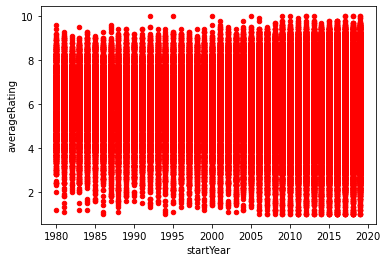

In [31]:
rated.plot(x="startYear", y="averageRating", kind="scatter", color="r")

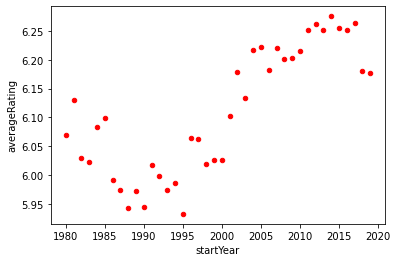

In [32]:
ave_rate = rated.groupby("startYear").mean()
ave_rate = pd.DataFrame(ave_rate).reset_index()
ave_rate.plot(x="startYear", y="averageRating", kind="scatter", color="r")

# Visualization

Want

		1-How does economic growth affect the overall supply of the cinema entertainment?
			-Plot GDP per capita, Consumer Sentiment, unemployment rate, movie releases:
				-We got the movie releases (=box_office_qrt) graph
				-We got the gdp_capita graph
				-We got the consumer_sent graph
				-We got the unemp graph
		1.1-How does economic growth affect the overall supply of the cinema entertainment?
			-Plot GDP per capita, Consumer Sentiment, unemployment rate, tickets sold per year quarter
				-We got the movie gross revenues (=box_office_qrt) graph
				-We got the gdp_capita graph
				-We got the consumer_sent graph
				-We got the unemp graph
		2-How does it shift the respective market shares of different genres?
		3-Do other external factors besides the state of the economy have more explanatory power concerning supply and demand?--> here we could look at netflix.
		4-Consumer confidence increased. *Key indicator to evaluate*


### Influence of economic variables in the SUPPLY side of the film industry





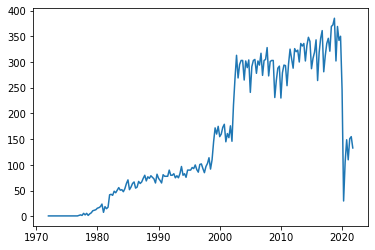

In [33]:
plt.plot(box_office_qrt.Releases)

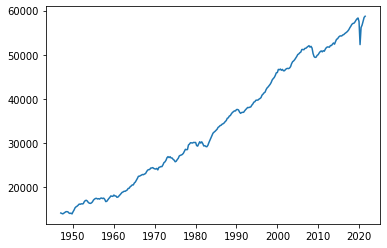

In [34]:
plt.plot(gdp_capita.Date, gdp_capita.gdp_per_capita)

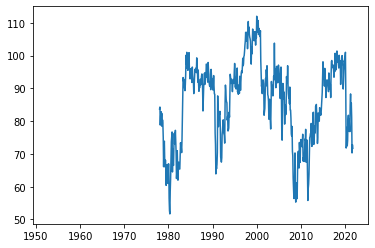

In [35]:
plt.plot(consumer_sent.Date, consumer_sent.consum_sent)

In [36]:
data_qrt.head(10)

,Date,UNRATE,consum_sent,gas_price,GDP,gdp_per_capita,PCE,debt_pct_income
0,1952-10-01,2.750000,86.2,NaN,2650.431,16776.0,14.508,NaN
1,1953-01-01,2.700000,90.7,NaN,2699.699,17025.0,14.563,NaN
2,1953-04-01,2.566667,NaN,NaN,2720.566,17093.0,14.585,NaN
3,1953-07-01,2.733333,80.8,NaN,2705.258,16920.0,14.664,NaN
4,1953-10-01,3.700000,80.7,NaN,2664.302,16586.0,14.728,NaN
5,1954-01-01,5.266667,82.0,NaN,2651.566,16436.0,14.802,NaN
6,1954-04-01,5.800000,82.9,NaN,2654.456,16387.0,14.782,NaN
7,1954-07-01,5.966667,NaN,NaN,2684.434,16496.0,14.733,NaN
8,1954-10-01,5.333333,87.0,NaN,2736.960,16737.0,14.718,NaN
9,1955-01-01,4.733333,95.9,NaN,2815.134,17144.0,14.765,NaN


In [37]:
# plt.plot(data_qrt.Date, data_qrt.UNRATE, data_qrt.Date)

In [38]:
data_box_year_pct = data_box_year.pct_change()
data_box_year_pct.head()

,UNRATE,consum_sent,gas_price,GDP,gdp_per_capita,PCE,debt_pct_income,Releases,gross
Date,,,,,,,,,
1982-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1983-01-01,-0.011159,0.285522,NaN,0.045839,0.036341,0.042449,-0.005020,0.128788,-0.123603
1984-01-01,-0.217882,0.115487,NaN,0.072366,0.063042,0.037885,0.027746,0.134228,0.088251
1985-01-01,-0.042175,-0.044199,NaN,0.041696,0.032460,0.034892,0.074224,0.130178,-0.053268
1986-01-01,-0.026651,0.017442,NaN,0.034626,0.025287,0.021806,0.036602,0.052356,-0.001612


In [39]:
data_qrt_Datex = data_qrt.set_index('Date')
data_qrt_Datex_pct = data_qrt_Datex.pct_change()
data_qrt_Datex_pct.head()

,UNRATE,consum_sent,gas_price,GDP,gdp_per_capita,PCE,debt_pct_income
Date,,,,,,,
1952-10-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1953-01-01,-0.018182,0.052204,NaN,0.018589,0.014843,0.003791,NaN
1953-04-01,-0.049383,0.000000,NaN,0.007729,0.003994,0.001511,NaN
1953-07-01,0.064935,-0.109151,NaN,-0.005627,-0.010121,0.005417,NaN
1953-10-01,0.353659,-0.001238,NaN,-0.015139,-0.019740,0.004364,NaN


Imported new dataset--> recession bars

In [40]:
%matplotlib inline

In [129]:
import matplotlib.pylab as plt
us_rec = get_fred("USREC") #recession indicator data
us_rec["Date"] = pd.to_datetime(us_rec["Date"])

'''
from google.colab import files
#uploaded = files.upload()
'''


In [137]:
'''
import io
us_rec1 = pd.read_csv(io.BytesIO(uploaded['USREC_1.csv']))
us_rec1["Date"] = pd.to_datetime(us_rec1["Date"])
#us_rec1 = us_rec1.set_index('DATE')
'''
#us_rec_10000 = us_rec.loc[:,1] *= 10000

'\nimport io\nus_rec1 = pd.read_csv(io.BytesIO(uploaded[\'USREC_1.csv\']))\nus_rec1["Date"] = pd.to_datetime(us_rec1["Date"])\n#us_rec1 = us_rec1.set_index(\'DATE\')\n'

(0.0, 1.0)

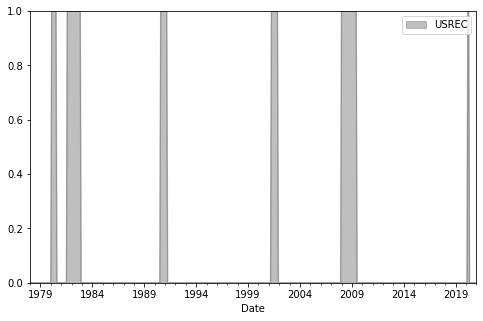

In [133]:
# make sure date columns are actual dates

import matplotlib.pyplot as plt
import math

# create plot (practice command)
fig, ax = plt.subplots()
us_rec.plot.area(ax=ax, figsize=(8, 5), x='Date', alpha=0.5, color="gray")
plt.xlim("1978-01-01", "2021-01-01")
plt.ylim(0, 1)
#y = [0.5, 2]
#low = min(y)
#high = max(y)
#plt.ylim([math.ceil(low-0.5*(high-low)), math.ceil(high+0.5*(high-low))])

Now, I need to plot the recession bars also for the negative y-axis

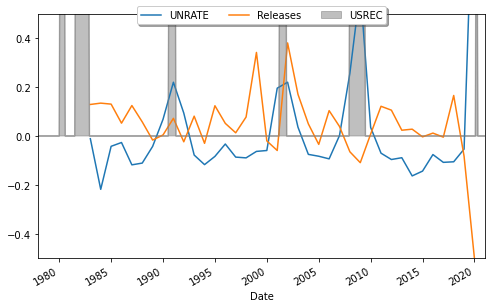

In [128]:
# Practice

fig, ax = plt.subplots()

ax.plot(data_box_year_pct[['UNRATE']], label = 'UNRATE')
ax.plot(data_box_year_pct[['Releases']], label = 'Releases')
us_rec.plot.area(ax=ax, figsize=(8, 5), x='Date', alpha=0.5, color="gray")
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.05), ncol=3, fancybox=True, shadow=True)
plt.xlim("1978-01-01", "2021-01-01")
plt.ylim(-0.5, 0.5)


plt.show()

Plots showing the economic variables and releases

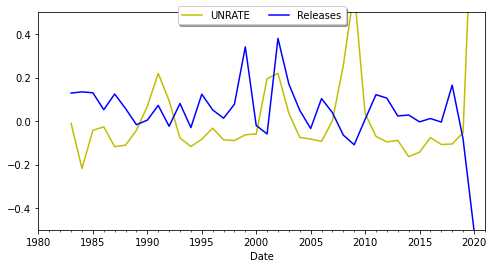

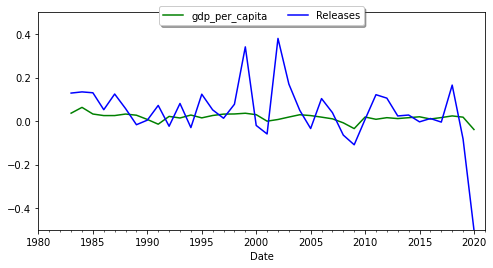

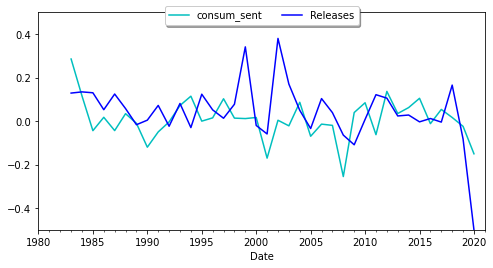

In [44]:
# 0-Plot for the econoomic conditions with percentage change on the y-axis
data_box_year_pct[['UNRATE', 'Releases']].plot(color = ('y','b'), figsize = (8, 4))
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.05), ncol=3, fancybox=True, shadow=True)
plt.xlim("1980-01-01", "2021-06-01")
plt.ylim(-0.5, 0.5)

data_box_year_pct[['gdp_per_capita', 'Releases']].plot(color = ('g','b'), figsize = (8, 4))
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.05), ncol=3, fancybox=True, shadow=True)
plt.xlim("1980-01-01", "2021-06-01")
plt.ylim(-0.5, 0.5)

data_box_year_pct[['consum_sent', 'Releases']].plot(color = ('c','b'), figsize = (8, 4))
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.05), ncol=3, fancybox=True, shadow=True)
plt.xlim("1980-01-01", "2021-06-01")
plt.ylim(-0.5, 0.5)

plt.show()

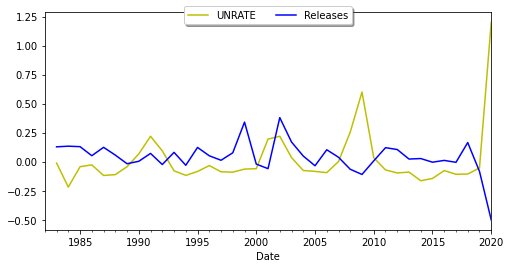

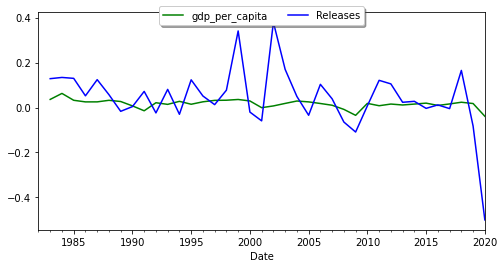

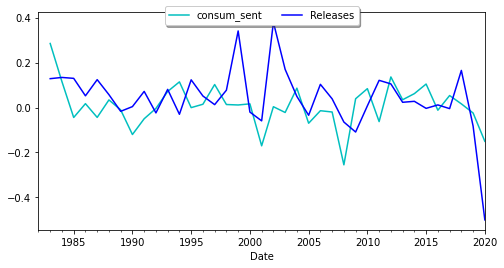

In [45]:
# 1-Plot for the econoomic conditions with percentage change on the y-axis
data_box_year_pct[['UNRATE', 'Releases']].plot(color = ('y','b'), figsize = (8, 4))
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.05), ncol=3, fancybox=True, shadow=True)

data_box_year_pct[['gdp_per_capita', 'Releases']].plot(color = ('g','b'), figsize = (8, 4))
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.05), ncol=3, fancybox=True, shadow=True)

data_box_year_pct[['consum_sent', 'Releases']].plot(color = ('c','b'), figsize = (8, 4))
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.05), ncol=3, fancybox=True, shadow=True)

plt.show()

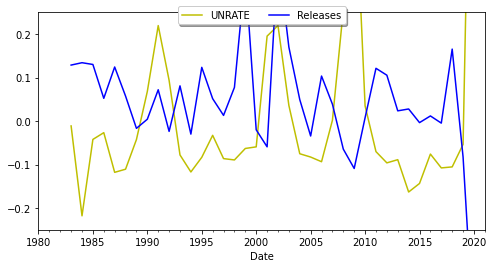

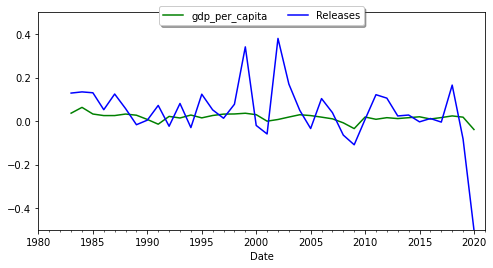

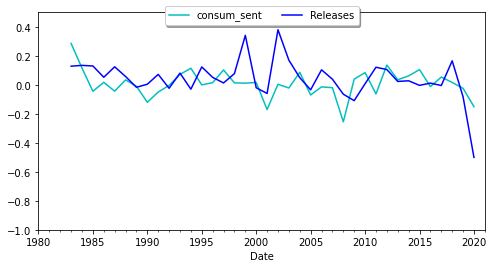

In [46]:
# 2-Plot for the econoomic conditions with percentage change on the y-axis

data_box_year_pct[['UNRATE', 'Releases']].plot(color = ('y','b'), figsize = (8, 4))
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.05), ncol=3, fancybox=True, shadow=True)
plt.xlim("1980-01-01", "2021-06-01")
plt.ylim(-0.25, 0.25)

data_box_year_pct[['gdp_per_capita', 'Releases']].plot(color = ('g','b'), figsize = (8, 4))
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.05), ncol=3, fancybox=True, shadow=True)
plt.xlim("1980-01-01", "2021-06-01")
plt.ylim(-0.5, 0.5)

data_box_year_pct[['consum_sent', 'Releases']].plot(color = ('c','b'), figsize = (8, 4))
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.05), ncol=3, fancybox=True, shadow=True)
plt.xlim("1980-01-01", "2021-06-01")
plt.ylim(-1, 0.5)

plt.show()

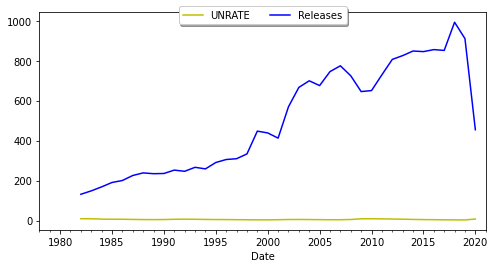

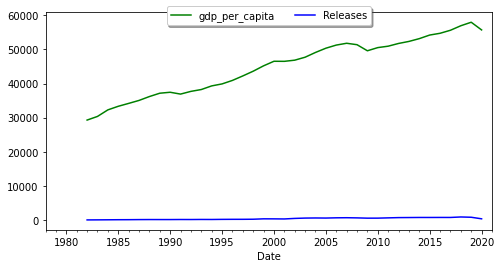

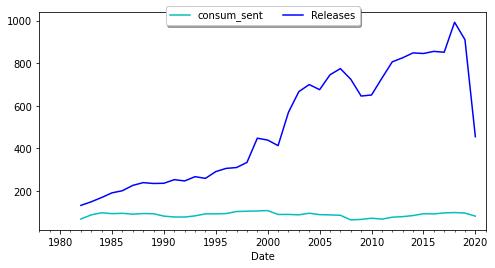

In [47]:
# 3-Plot for the econoomic conditions on the y-axis

data_box_year[['UNRATE', 'Releases']].plot(color = ('y','b'), figsize = (8, 4))
plt.xlim("1978-01-01", "2021-01-01")
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.05), ncol=3, fancybox=True, shadow=True)

data_box_year[['gdp_per_capita', 'Releases']].plot(color = ('g','b'), figsize = (8, 4))
plt.legend(loc = 5, prop = {'size': 10})
plt.xlim("1978-01-01", "2021-01-01")
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.05), ncol=3, fancybox=True, shadow=True)


data_box_year[['consum_sent', 'Releases']].plot(color = ('c','b'), figsize = (8, 4))
plt.legend(loc = 5, prop = {'size': 10})
plt.xlim("1978-01-01", "2021-01-01")
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.05), ncol=3, fancybox=True, shadow=True)

plt.show()

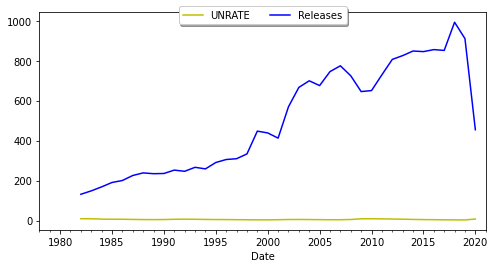

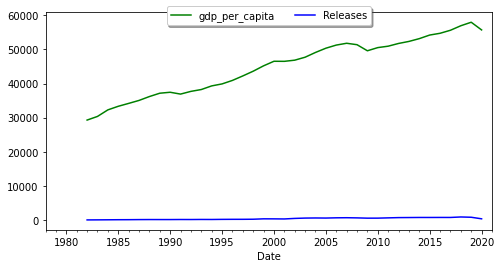

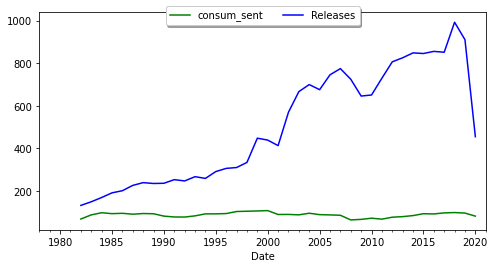

In [48]:
# 4-Plot for the econoomic conditions on the y-axis

data_box_year[['UNRATE', 'Releases']].plot(color = ('y','b'), figsize = (8, 4))
plt.legend(loc = 5, prop = {'size': 10})
plt.xlim("1978-01-01", "2021-01-01")
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.05), ncol=3, fancybox=True, shadow=True)

data_box_year[['gdp_per_capita', 'Releases']].plot(color = ('g','b'), figsize = (8, 4))
plt.legend(loc = 5, prop = {'size': 10})
plt.xlim("1978-01-01", "2021-01-01")
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.05), ncol=3, fancybox=True, shadow=True)

data_box_year[['consum_sent', 'Releases']].plot(color = ('g','b'), figsize = (8, 4))
plt.legend(loc = 5, prop = {'size': 10})
plt.xlim("1978-01-01", "2021-01-01")
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.05), ncol=3, fancybox=True, shadow=True)

plt.show()

### Influence of economic variables in the DEMAND side of the film industry


The variable for cumulative revenue is "gross".
I still need to add the recession bars.

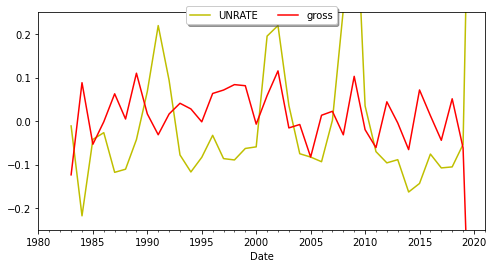

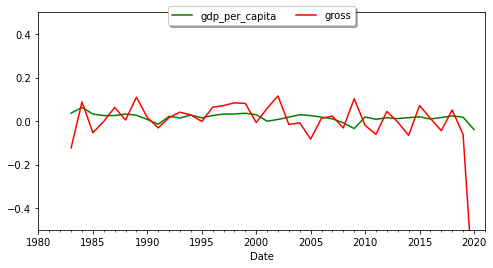

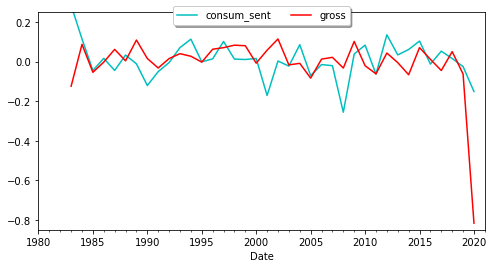

In [49]:
# 1-Plot for the econoomic conditions with percentage change on the y-axis

data_box_year_pct[['UNRATE', 'gross']].plot(color = ('y','r'), figsize = (8, 4))
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.05), ncol=3, fancybox=True, shadow=True)
plt.xlim("1980-01-01", "2021-06-01")
plt.ylim(-0.25, 0.25)

data_box_year_pct[['gdp_per_capita', 'gross']].plot(color = ('g','r'), figsize = (8, 4))
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.05), ncol=3, fancybox=True, shadow=True)
plt.xlim("1980-01-01", "2021-06-01")
plt.ylim(-0.5, 0.5)

data_box_year_pct[['consum_sent', 'gross']].plot(color = ('c','r'), figsize = (8, 4))
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.05), ncol=3, fancybox=True, shadow=True)
plt.xlim("1980-01-01", "2021-06-01")
plt.ylim(-0.85, 0.25)

plt.show()

The values of gross revenues are too large to plot them together with another variable.
The values of gross revenues make the other variables look flat.

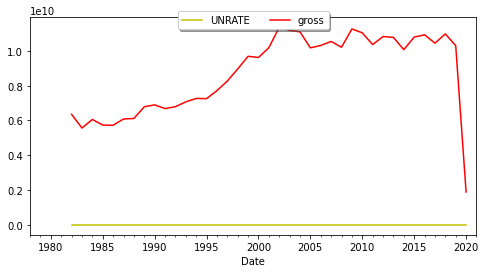

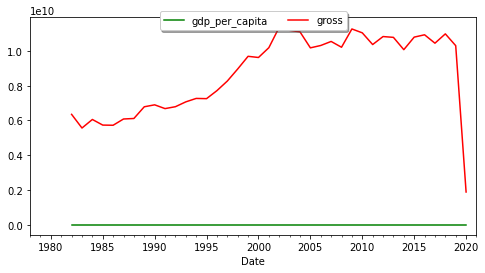

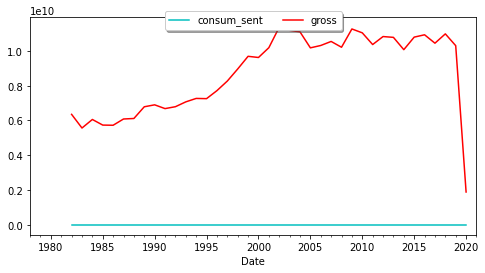

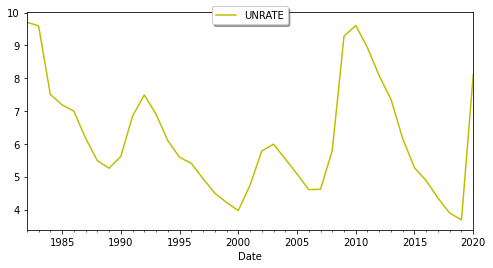

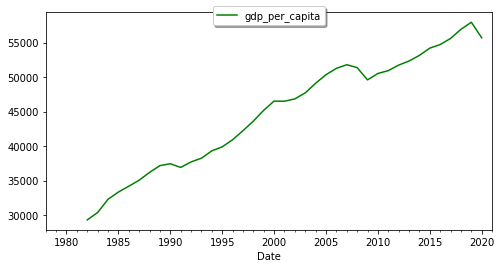

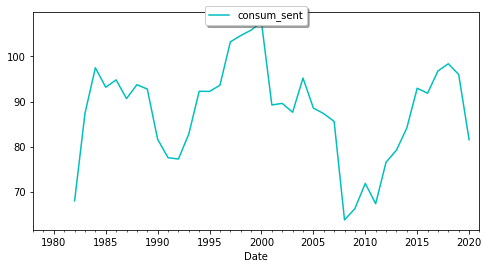

In [50]:
# 2-Plot for the economic conditions on the y-axis

data_box_year[['UNRATE', 'gross']].plot(color = ('y','r'), figsize = (8, 4))
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.05), ncol=3, fancybox=True, shadow=True)
plt.xlim("1978-01-01", "2021-01-01")

data_box_year[['gdp_per_capita', 'gross']].plot(color = ('g','r'), figsize = (8, 4))
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.05), ncol=3, fancybox=True, shadow=True)
plt.xlim("1978-01-01", "2021-01-01")

data_box_year[['consum_sent', 'gross']].plot(color = ('c','r'), figsize = (8, 4))
plt.legend(loc = 5, prop = {'size': 10})
plt.xlim("1978-01-01", "2021-01-01")
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.05), ncol=3, fancybox=True, shadow=True)

# The economic variables arer plotted alone from here on

data_box_year[['UNRATE']].plot(color = ('y'), figsize = (8, 4))
plt.legend(loc = 5, prop = {'size': 10})
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.05), ncol=3, fancybox=True, shadow=True)

data_box_year[['gdp_per_capita']].plot(color = ('g'), figsize = (8, 4))
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.05), ncol=3, fancybox=True, shadow=True)
plt.xlim("1978-01-01", "2021-01-01")

data_box_year[['consum_sent']].plot(color = ('c'), figsize = (8, 4))
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.05), ncol=3, fancybox=True, shadow=True)
plt.xlim("1978-01-01", "2021-01-01")


plt.show()